# Spike Sorting by Clustering


In this lab you'll build a basic spike sorting algorithm for electrophysiological recordings like those you might collect with a tetrode. The model is inspired by [MountainSort](https://github.com/flatironinstitute/mountainsort5), a popular spike sorting algorithm. We'll fit the model to synthetic data simulated with [SpikeInterface](https://github.com/SpikeInterface/spikeinterface), a tool that can generate realistic data with ground truth spike times.

## Setup

In [1]:
# Install dependencies
try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

In [2]:
# First, import necessary libraries.
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.distributions as dist

from jaxtyping import Float, Int
from torch import Tensor

### Load the data

In [3]:
# %%capture
# !wget -nc https://www.dropbox.com/s/tq0auevkswaa09y/sim_binary.imec.ap.bin
# !wget -nc https://www.dropbox.com/s/j0xcqk7v9n0fzc7/eMouseGroundTruth.mat
!cp ../data/01_simple_spike_sorting/lab01_data.pt . 

The data has four fields:
- `traces`: A $T \times C$ tensor of voltage measurements (in microvolts) over $T$ time steps and $C$ recording channels
- `true_spike_times`: A length $S$ tensor of spike times (in the range $0, \ldots, T-1$) corresponding to when spikes truly happened in this simulated dataset
- `true_spike_ids`: A length $S$ tensor of spike IDs (in the range $0,\ldots, N-1$, where $N$ denotes the number of neurons) representing which neuron produced the corresponding spike
- `sampling_frequency`: The sampling frequency of the recording (in Hz)

In [ ]:
# Load the data
data = torch.load("lab01_data.pt")
traces = data["traces"]
true_spike_times = data["true_spike_times"]
true_spike_ids = data["true_spike_ids"]
true_templates = data["true_templates"]

# Extract scalar constants 
SAMPLING_FREQUENCY = data["sampling_frequency"]
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = true_spike_times.shape[0]
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

### Helper functions

We provide two helper functions for plotting.
- `plot_slice` plots a slice of the data. It shows the spike train along with the voltage traces for each channel.
- `plot_waveforms` can be used to plot the waveforms for inferred spikes or the templates of a spike sorting model.

In [5]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None,
               units=r"$\mu V$"):
    """
    Plot a slice of the recording and the corresponding spike times.

    Parameters
    ----------
    traces : torch.Tensor
        The voltage traces.
    spike_times : torch.Tensor
        The spike times, in samples.
    spike_ids : torch.Tensor
        The spike IDs, taking values 0,1,2,...,num_neurons-1
    start_time : float
        The start time of the slice, in seconds.
    end_time : float
        The end time of the slice, in seconds.
    spacing : float
        The relative spacing between the traces in the plot.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1

    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()

    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)

    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")

    # Plot the voltage traces 
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel(rf"trace [{units}]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1: 
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [6]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   yunits: str=r"z-score",
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.

    Parameters
    ----------
    waveforms : torch.Tensor
        The waveforms (or templates) to plot.

    yunits : str
        The units of the y-axis. Default is "z-score".

    name : str
        The name of the waveforms (or templates) to plot. Default is "waveform".
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    fig, axs = plt.subplots(num_channels, num_waveforms, 
                            figsize=(1.25 * num_waveforms, 1.25 * num_channels), 
                            sharex=True, sharey=True)
    lim = 1.05 * waveforms.abs().max()
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            # axs[i,j].set_xlabel("time [samples]")
            # axs[i,j].set_title(f"waveform {j}\n channel {i}")
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [{yunits}]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    plt.tight_layout()
    
    return fig, axs

Use the helper function to plot the first second of the data.

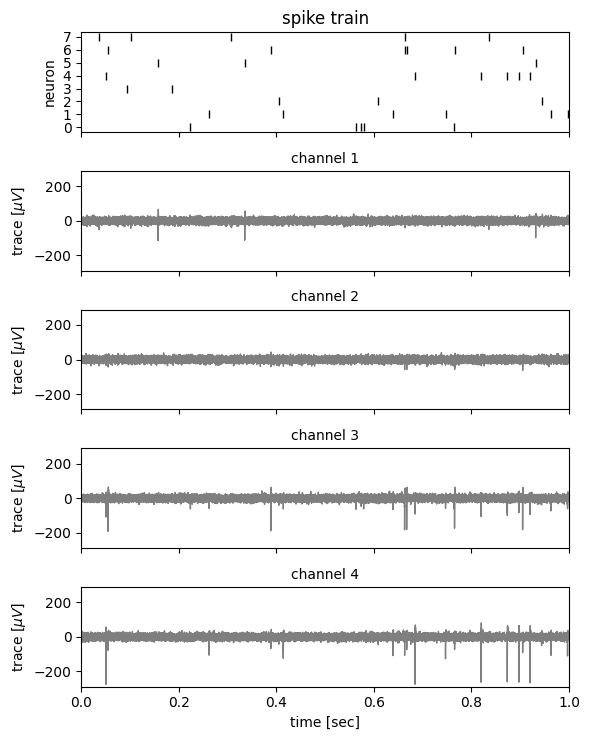

In [7]:
_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.0,
    end_time=1.0,
)

Now plot a 50 ms snippet so we can better see the voltage traces around each spike.

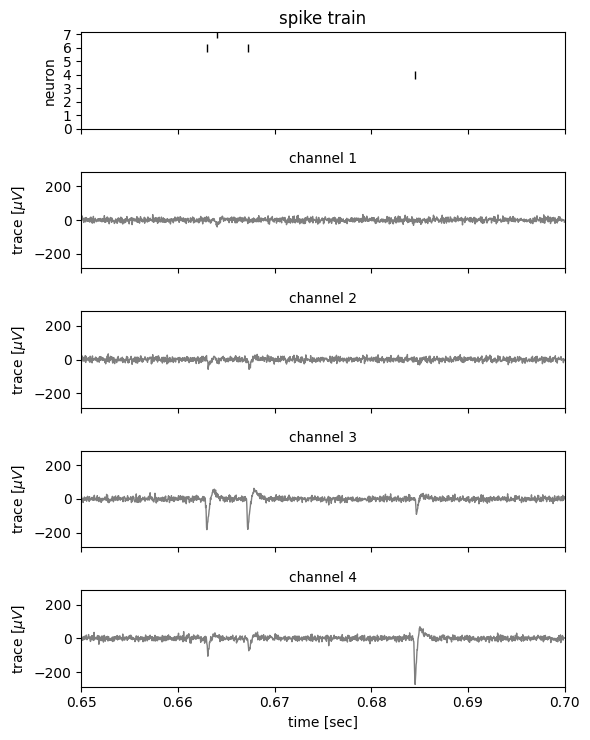

In [8]:
_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.65,
    end_time=0.70,
)

Finally, plot the true templates for each neuron in this synthetic dataset.
Each time a neuron spikes, these templates are superimposed to create the traces above.

Text(0.5, 1.05, "True neurons' templates")

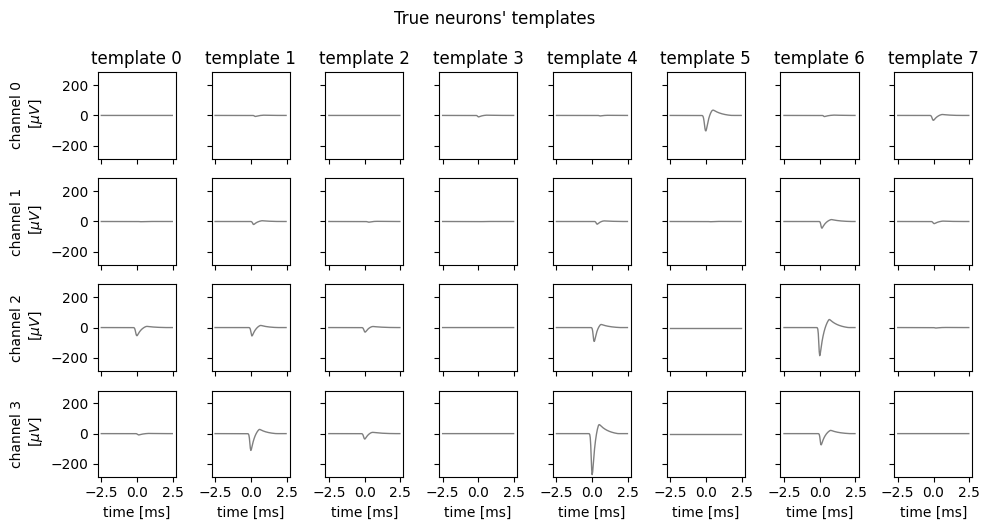

In [9]:
fig, axs = plot_waveforms(true_templates, yunits=r"$\mu V$", name="template")
fig.suptitle("True neurons' templates", y=1.05)

Notice that some neuron produce larger amplitude spikes than others. For example, neuron 4 produces large spikes on channel 3, whereas neuron 3 produces very small spikes.

## Part 1: Infer spike times

The next step of the process is to infer spike times by looking for pronounced dips in the voltage on at least one channel. In this simulated dataset, the noise on each channel has a standard deviation of about 10 $\mu\mathrm{V}$. To stand out from the noise, a spike should be about 4 standard deviations below the mean, or -40 $\mu\mathrm{V}$ in magnitude. Moreover, spikes should be separated from one another by at least 3 ms. 

### Problem 1a: Find negative peaks in the data

Use the `signal.find_peaks` function to extract negative peaks on at least one channel. A simple way to do so is to compute the minimum value across channels for each time step, then negate that signal and look for peaks that match the heigh and distance criteria described above.

In [10]:
inferred_spike_times, _ = signal.find_peaks(
    -traces.min(axis=1).values,
    distance=int(0.003 * SAMPLING_FREQUENCY),
    height=40
    )

inferred_spike_times = torch.tensor(inferred_spike_times)
num_inferred_spikes = inferred_spike_times.shape[0]

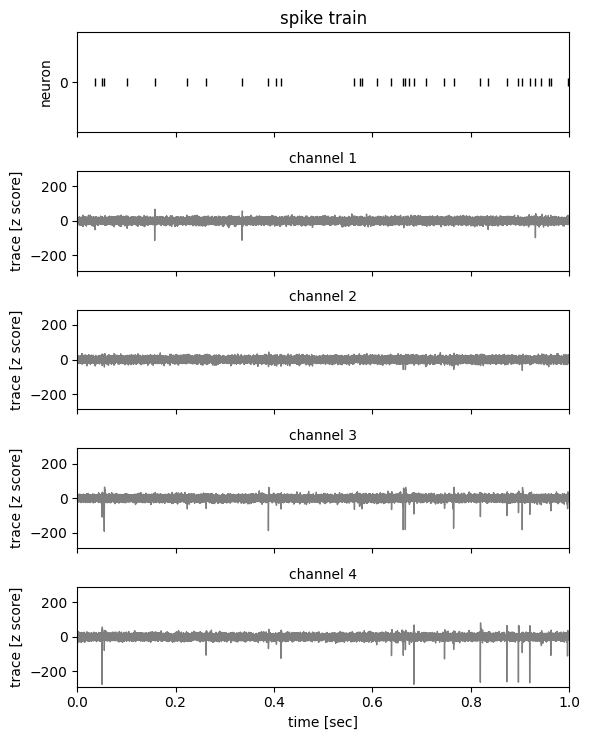

In [11]:
# Plot the inferred spike times with dummy spike ids
dummy_spike_ids = torch.zeros_like(inferred_spike_times)

_ = plot_slice(
    traces,
    inferred_spike_times,
    dummy_spike_ids,
    start_time=0.,
    end_time=1.0,
    units="z score",
)

### Problem 1b: Evaluate the inferred spike times

To evaluate the inferred spikes, let's think of it as a binary classification problem.
First, construct a binary tensor of length `NUM_SAMPLES / WINDOW_SIZE` that specifies if 
there was a true spike (from any neuron) in each window of time. Then construct an analogous
binary tensor for the inferred spike times. If a true spike and an inferred spike are present
in the same window, the inferred spike is a _true positive_. If there is an inferred spike but 
not true spike in the same window, then it's a _false positive_. True and false negatives are 
defined similarly. 


In [12]:
def evaluate_inferred_spikes(
        inferred_spike_times: Int[Tensor, "num_inferred_spikes"],
        true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    Evaluate the inferred spike times against the true spike times.
    We count a inferred spike as a true positive if it is within
    window_size seconds of a true spike. We count a true spike
    as a false negative if it is not within window_size seconds
    of a inferred spike. False positives and true negatives are 
    defined similarly.

    Parameters
    ----------
    inferred_spike_times : torch.Tensor
        The inferred spike times, in samples.
    true_spike_times : torch.Tensor
        The true spike times, in samples.

    """
    # Create a boolean tensors to mark true spikes
    true_spike_mask = torch.zeros(NUM_SAMPLES // WINDOW_SIZE, dtype=torch.bool)
    true_spike_mask[true_spike_times // WINDOW_SIZE] = True
    
    # Create a boolean tensors to mark inferred spikes
    inferred_spike_mask = torch.zeros(NUM_SAMPLES // WINDOW_SIZE, dtype=torch.bool)
    inferred_spike_mask[inferred_spike_times // WINDOW_SIZE] = True
    
    # Count true positives, false positives, false negatives, and true negatives
    tp = (true_spike_mask & inferred_spike_mask).sum().item()
    fp = (inferred_spike_mask & ~true_spike_mask).sum().item()
    fn = (~inferred_spike_mask & true_spike_mask).sum().item()
    tn = (~inferred_spike_mask & ~true_spike_mask).sum().item()

    # Return some summary statistics of this binary classifier
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)
    
perf_stats = evaluate_inferred_spikes(
    inferred_spike_times,
    true_spike_times
)
    

Now print the number of true positives ($TP$), false positives ($FP$), false negatives ($FN$), and true negatives ($TN$).

Based on these statistics, compute and print the precision and recall the spike detector,
\begin{align*}
\mathrm{precision} &= \frac{TP}{TP + FP} \\
\mathrm{recall} &= \frac{TP}{TP + FN}
\end{align*}

In [13]:
print(f"True Positives:  {perf_stats['tp']}")
print(f"False Positives: {perf_stats['fp']}")
print(f"False Negatives: {perf_stats['fn']}")
print(f"True Negatives:  {perf_stats['tn']}")
print("")
print(f"Recall:          {perf_stats['tp'] / (perf_stats['tp'] + perf_stats['fn']):.2f}")
print(f"Precision:       {perf_stats['tp'] / (perf_stats['tp'] + perf_stats['fp']):.2f}")

True Positives:  2153
False Positives: 402
False Negatives: 526
True Negatives:  20919

Recall:          0.80
Precision:       0.84


### Collect the voltage traces surrounding each inferred spike

Next, extract a window of the voltage trace surrounding each inferred spike. 
We use a simple for loop to fill in the waveforms one at a time.


In [14]:
spike_waveforms = torch.zeros((num_inferred_spikes, WINDOW_SIZE, NUM_CHANNELS))

for i, t in enumerate(inferred_spike_times):
    slc = slice(t - WINDOW_SIZE // 2, t + WINDOW_SIZE // 2)
    spike_waveforms[i] = traces[slc]

Text(0.5, 1.05, 'First 5 inferred spike waveforms')

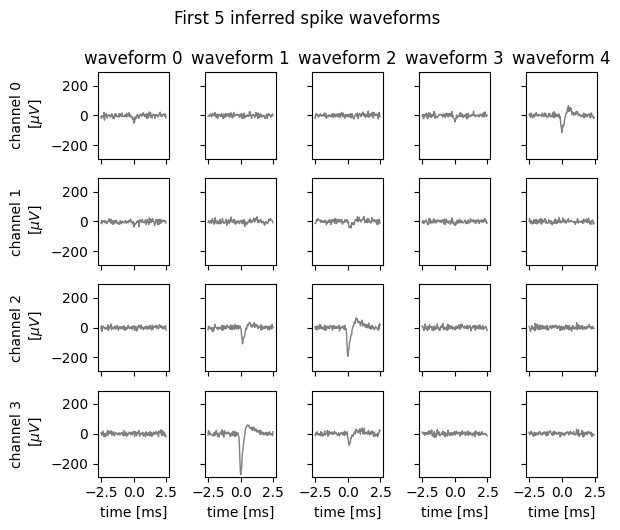

In [15]:
# Plot a few of the waveforms
fig, axs = plot_waveforms(spike_waveforms[:5], yunits=r"$\mu V$", name="waveform")
fig.suptitle("First 5 inferred spike waveforms", y=1.05)

## Part 2: Simple Spike Sorting

Now let's write a simple spike sorting algorithm to cluster the spikes based on their waveforms! 

Let $\mathbf{X}_s \in \mathbb{R}^{D \times C}$ denote the waveform of spike $s$. It is $D$ samples long and $C$ channels wide, with entries denoted by,
\begin{align*}
\mathbf{X}_s = 
\begin{bmatrix}
x_{s,1,1} & \cdots & x_{s,1,C} \\
\vdots & & \vdots \\
x_{s,D,1} & \cdots & x_{s,D,C} 
\end{bmatrix}
\end{align*} 

Assume each spike waveform can be attributed to one of $N$ neurons. 
Each neuron $n=1,\ldots,N$ is associated with a template, $\boldsymbol{\mu}_n \in \mathbb{R}^{D \times C}$ with entries,
\begin{align*}
\boldsymbol{\mu}_n = 
\begin{bmatrix}
\mu_{n,1,1} & \cdots & \mu_{n,1,C} \\
\vdots & & \vdots \\
\mu_{n,D,1} & \cdots & \mu_{n,D,C} 
\end{bmatrix}
\end{align*} 

Let $z_s \in \{1,\ldots, N\}$ be a latent variable that specifies which neuron produced spike $s$. 
We assume that each spike waveform equal to the template of the neuron that produced it, plus Gaussian noise,
\begin{align*}
\mathbf{X}_s &= \boldsymbol{\mu}_{z_s} + \boldsymbol{\epsilon}_s,
\end{align*}
where $\boldsymbol{\epsilon}_s \in \mathbb{R}^{D \times C}$ is a matrix of iid Gaussian random variables, each with mean zero and variance $\sigma^2$. 

In other words, we assume a Gaussian likelihood model of the form,
\begin{align*}
p(\mathbf{X}_s \mid z_s = n) 
&= \prod_{d=1}^D \prod_{c=1}^C 
\mathcal{N}(x_{s,d,c} \mid \mu_{n,d,c}, \sigma^2).
\end{align*}

where

\begin{align*}
\mathcal{N}(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2 \sigma^2}(x - \mu)^2}
\end{align*}

is the probability density function (pdf) of a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ evaluated at a point $x$.

To fit the model, we need to infer the latent spike IDs $z_s$ for $s=1,\ldots,S$, as well as the templates $\boldsymbol{\mu}_n$ for $n=1,\ldots,N$.




### Problem 2a: Deriving the fitting algorithm

We will fit the model by maximizing the log probability with respect to the latent variables, $z_s$, and the templates, $\boldsymbol{\mu}_n$. In particular, we will use coordinate ascent, alternating between updating the latent variables while keeping the templates fixed, and then updating the templates given the latent variables. 

Let 
- $\mathbf{X} = \{\mathbf{X}_s\}_{s=1}^S$ denote the set of all spike waveforms, 
- $\mathbf{z} = \{z_s\}_{s=1}^S$ denote the set of spike assignments, and 
- $\boldsymbol{\mu} = \{\boldsymbol{\mu}_n\}_{n=1}^N$ denote the set of all templates. 

The log probability is,

\begin{align*}
\log p(\mathbf{X}, \mathbf{z} \mid \boldsymbol{\mu})
&= \sum_{s=1}^S \log p(\mathbf{X}_s \mid z_s) + \log p(z_s)
\end{align*}

Assume that all spike assignments are equally probable under the prior, so that $p(z_s = n) = \frac{1}{N}$ and $\log p(z_s) = -\log N$ always. Then, substituting the likelihood above, we have the following objective function,

\begin{align*}
L(\mathbf{z}, \boldsymbol{\mu}) 
&\triangleq \log p(\mathbf{X}, \mathbf{z} \mid \boldsymbol{\mu}) \\
&= \sum_{s=1}^S \sum_{d=1}^D \sum_{c=1}^C \log \mathcal{N}(x_{s,c,d} \mid \mu_{z_s,c,d}, \sigma^2) + \mathrm{const}
\end{align*}

First, show that if you fix the spike assignments, $\mathbf{z}$, the log probability is maximized by setting,
\begin{align*}
\mu_{n,d,c} &= \frac{1}{S_n} \sum_{s:z_s = n} x_{s,c,d}
\end{align*}
where $S_n = \sum_s \mathbb{I}[z_s=n]$ is the number of spikes assigned to neuron $n$.

---

_Your answer here_

---

### Problem 2b: Updating the spike assignments

Next, show that when you fix the templates, the log probability is optimized by setting,

\begin{align*}
z_s &= \arg \max_n \; \sum_{d=1}^D \sum_{c=1}^C \log \mathcal{N}(x_{s,c,d} \mid \mu_{n,c,d}, \sigma^2).
\end{align*}

Or equivalently,

\begin{align*}
z_s &= \arg \min_n \; \|\mathbf{X}_s - \boldsymbol{\mu}_n\|_F^2.
\end{align*}

where $\|\mathbf{A}\|_F^2 = \sum_{d=1}^D \sum_{c=1}^C a_{d,c}^2$ is the squared Frobenius norm of a matrix $\mathbf{A} \in \mathbb{R}^{D \times C}$.

---

_Your answer here_

---

### Problem 2c: Implement the model and algorithm

Complete the starter code below to implement this simple spike sorting model and algorithm.

In [16]:
class SimpleSpikeSorter:
    """
    A simple spike sorter that uses a Gaussian mixture model (GMM) to fit the templates.
    The GMM is fit to the putative spike waveforms using coordinate ascent on the 
    log joint probability of the model.

    Parameters
    ----------
    initial_templates : torch.Tensor
        The initial templates for the GMM, with shape (num_neurons, window_size, num_channels).

    noise_scale : float
        The scale of the noise in the GMM. This is used to compute the log likelihood of
        the spike waveforms given the templates. The noise scale is assumed to be the same
        for all neurons, samples, and channels. Note that the scale is the standard deviation
        of the noise, not the variance.
    """
    templates: Float[Tensor, "num_neurons window_size num_channels"]
    noise_scale: float

    def __init__(
            self,
            initial_templates: Float[Tensor, "num_neurons window_size num_channels"],
            noise_scale: float = 10.0,
            ) -> None:
        self.templates = initial_templates
        self.noise_scale = noise_scale

    @property
    def num_neurons(self) -> int:
        return self.templates.shape[0]
    
    def log_probability(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            spike_ids: Int[Tensor, "num_spikes"]) -> float:
        """
        Compute the log probability of the spike waveforms given the templates.
        """
        # Compute the log likelihood of each spike waveform given each template
        lls = dist.Normal(
            loc=self.templates[spike_ids],
            scale=self.noise_scale
        ).log_prob(spike_waveforms).sum(dim=(1, 2))

        # Compute the average log likelihood
        return lls.mean()

    def update_templates(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            spike_ids: Int[Tensor, "num_spikes"]):
        """
        Update the templates using the spike waveforms and spike IDs.
        """
        for i in range(self.num_neurons):
            # Get the spike waveforms for this neuron
            self.templates[i] = spike_waveforms[spike_ids == i].mean(dim=0)

    def update_spike_ids(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            ) -> Int[Tensor, "num_spikes"]:
        """
        Update the spike IDs using the templates and spike waveforms.
        """
        # Compute the log likelihood of each spike waveform given each template
        lls = dist.Normal(
            loc=self.templates[None, :, :, :],
            scale=self.noise_scale
        ).log_prob(spike_waveforms[:, None, :, :]).sum(dim=(2, 3))

        # Assign each spike waveform to the template with the highest log likelihood
        return lls.argmax(dim=1)
    
    def fit(self, 
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            num_iterations: int=10,
            ) -> tuple[Float[Tensor, "num_iterations"], Int[Tensor, "num_spikes"]]:
        """
        Fit the GMM to the spike waveforms using coordinate ascent on the log joint probability.
        """
        # Initialize the spike IDs
        spike_ids = self.update_spike_ids(spike_waveforms)

        # Iterate to update the templates and spike IDs
        lps = []
        for itr in range(num_iterations):
            lps.append(self.log_probability(spike_waveforms, spike_ids))
            print(f"iteration {itr}: log probability = {lps[-1]:.2f}")

            # Update the templates and spike IDs
            self.update_templates(spike_waveforms, spike_ids)
            spike_ids = self.update_spike_ids(spike_waveforms)

        # Return the final spike IDs
        return torch.tensor(lps), spike_ids

Run the coordinate ascent algorithm to fit the model!

In [17]:
num_neurons = 8

# Initialize the spike sorter with random templates
torch.manual_seed(220)
initial_templates = spike_waveforms[torch.randint(0, num_inferred_spikes, (num_neurons,))]
spike_sorter = SimpleSpikeSorter(initial_templates)

# Fit the spike sorter to the putative spike waveforms
lps, inferred_spike_ids = spike_sorter.fit(
    spike_waveforms,
    num_iterations=10,
)

iteration 0: log probability = -2638.94
iteration 1: log probability = -2276.83
iteration 2: log probability = -2253.49
iteration 3: log probability = -2252.00
iteration 4: log probability = -2251.27
iteration 5: log probability = -2251.19
iteration 6: log probability = -2251.19
iteration 7: log probability = -2251.19
iteration 8: log probability = -2251.19
iteration 9: log probability = -2251.19


Text(0, 0.5, 'log probability')

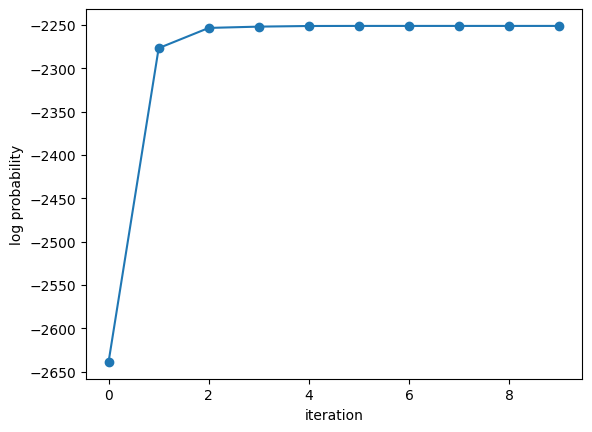

In [18]:
plt.plot(lps, '-o')
plt.xlabel("iteration")
plt.ylabel("log probability")

Text(0.5, 1.05, 'Inferred templates')

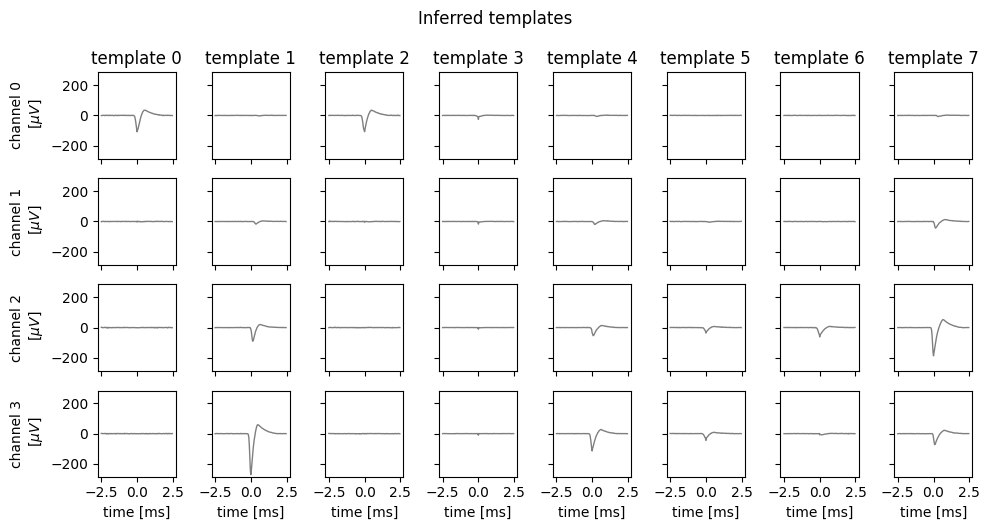

In [19]:
fig, axs = plot_waveforms(spike_sorter.templates, yunits=r"$\mu V$", name="template")
fig.suptitle("Inferred templates", y=1.05)

### Compare IDs of the true neurons that match each inferred spike

The function below computes the identities of the true neurons corresponding
to each inferred spike. For each inferred spike time, first determine if there 
is a true spike within a small window of that time. If so, find the ID of the true 
neuron that generated that spike. Otherwise, declare the inferred spike to be a false 
positive, indicated by -1. 


In [20]:
def match_true_and_inferred_spikes(
        inferred_spike_times: Int[Tensor, "num_inferred_spikes"],
        true_spike_times: Int[Tensor, "num_true_spikes"],
        true_spike_ids: Int[Tensor, "num_true_spikes"]
        ) -> Int[Tensor, "num_inferred_spikes"]:
    """
    Match the inferred spike times to the true spike times.
    For each inferred spike, find the closest true spike within a window size.
    If the closest true spike is within the window size, assign the inferred spike
    to the true spike ID. If not, assign the inferred spike to -1 (no match).
    The matching is done with a simple for loop, which is not efficient for large
    spike trains. However, it is simple and easy to understand.

    Parameters
    ----------
    inferred_spike_times : torch.Tensor
        The inferred spike times, in samples.
    true_spike_times : torch.Tensor
        The true spike times, in samples.
    true_spike_ids : torch.Tensor
        The true spike IDs, taking values 0,1,2,...,true_num_neurons-1
    window_size : int
        The window size, in samples.
    sampling_frequency : int
        The sampling frequency of the recording.

    Returns
    -------
    matching_spike_ids : torch.Tensor
        The IDs of the true neurons that produced the inferred spike.
        The tensor takes values -1,0,1,2,...,num_neurons-1, where -1 indicates 
        that the inferred spike does not match any true spike within the window size.

    """
    # For each inferred spike, find the closest true spike
    matching_spike_ids = torch.full((inferred_spike_times.shape[0],), -1)
    for i, inferred_time in enumerate(inferred_spike_times):
        # Find the closest true spike within the window size
        match = torch.min(abs(true_spike_times - inferred_time), dim=0)
        if match.values < WINDOW_SIZE / 2:
            matching_spike_ids[i] = true_spike_ids[match.indices]

    return matching_spike_ids

matching_spike_ids = match_true_and_inferred_spikes(
    inferred_spike_times,
    true_spike_times,
    true_spike_ids
)

### Problem 2d: Compare the true and inferred spike assignments

Create a confusion matrix that counts how many times each inferred spike assignment
was matched to either a false positive (-1) or a true neuron $n$ for $n=1,\ldots,N_{\mathsf{true}}$.

Show this confusion matrix using `plt.imshow`. Remember to label your axes and include a colorbar!

Text(0.5, 0.98, 'Confusion Matrix')

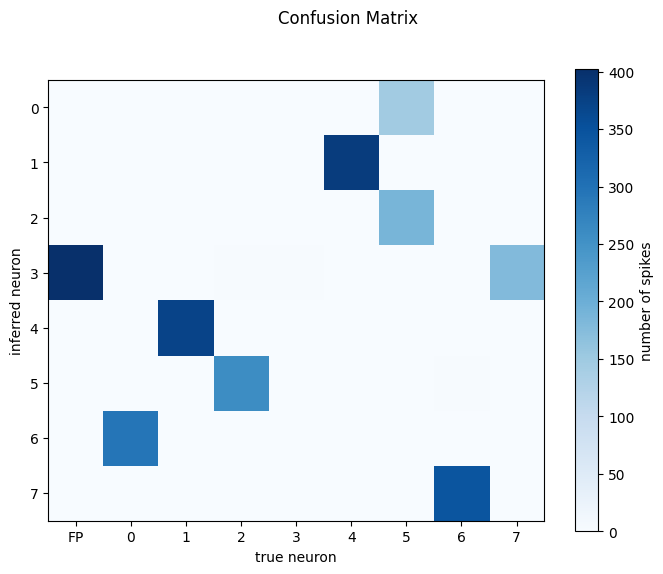

In [21]:
# Count the number of times each inferred neuron matched a spike from each true neuron
# or was a false positive.
confusion_matrix = torch.zeros((num_neurons, TRUE_NUM_NEURONS+1), dtype=torch.int)
for i in range(num_neurons):
    confusion_matrix[i, 0] = (matching_spike_ids[inferred_spike_ids == i] == -1).sum()
    for j in range(TRUE_NUM_NEURONS):
        confusion_matrix[i, j+1] = (matching_spike_ids[inferred_spike_ids == i] == j).sum()

# Plot the counts
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, cmap='Blues')
plt.xticks(torch.arange(0, TRUE_NUM_NEURONS+1), 
           ["FP"] + [i for i in range(TRUE_NUM_NEURONS)])
plt.xlabel("true neuron")
plt.ylabel("inferred neuron")
plt.colorbar(label="number of spikes")
plt.suptitle("Confusion Matrix")

## Part 3: Generalizations

1. How would you change the model to account for neurons that have different firing rates?

2. How would you generalize this model if spikes from the same neuron could have different amplitudes? That is, on average $\mathbf{X}_s$ equals the template $\boldsymbol{\mu}_{z_s}$, but they can be scaled up or down by a random number $a_s > 0$. Describe how you would update your model to allow for this extra form of variability.

3. Here we assumed that we knew the number of neurons, but of course that's unrealistic. How would you estimate the number of neurons in a data-driven manner?


## Submission Instructions

_TODO_